# Instructions to use this notebook
This notebook follows steps from https://huggingface.co/learn/nlp-course/chapter7/7?fw=pt

There are 2 other important files in the same folder:
- model.py (contains our custom model architecture)
- utils.py (contains our preprocessing and metric functions)

If you want to define your custom dense layers at the end, you should only make changes to `CustomDenseLayers` class in `model.py`

# Install & Import necessary libraries

In [4]:
# Install Hugging Face libraries
! pip install datasets transformers accelerate evaluate

You should consider upgrading via the 'c:\users\jian cheng\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


In [5]:
# Import Std and Huggingface libraries
from tqdm.auto import tqdm
import numpy as np

import torch
from torch.optim import AdamW
from torch.utils.data import DataLoader

from datasets import load_dataset
from transformers import default_data_collator, get_scheduler
from transformers import AutoTokenizer
from accelerate import Accelerator

Please RERUN the below cell whenever you make changes to `model.py` or `utils.py` file.

In [6]:
# Import custom models and helper functions
%load_ext autoreload
%autoreload 2
from model import DistilBertCustomDense
import utils

In [7]:
raw_datasets = load_dataset("squad", split="validation")

In [8]:
print(raw_datasets.shape)

(10570, 5)


In [9]:
from datasets import load_dataset

# Define a function to categorize questions
def categorize_question(example):
    question = example['question'].lower()
    if 'date' in question:
        return 'date'
    if 'during' in question:
        return 'during'
    if 'how are' in question:
        return 'how are'
    if 'how big' in question or 'how large' in question:
        return 'how big/size'
    if 'how many' in question or 'how much' in question:
        return 'how m/m'
    if 'how old' in question:
        return 'how old'
    if 'what time' in question:
        return 'what time'
    if 'what' in question or 'which' in question:
        return 'what'
    if 'when' in question:
        return 'when'
    if 'where' in question:
        return 'where'
    if 'who' in question:
        return 'who'
    if 'whom' in question:
        return 'whom'
    if 'why' in question:
        return 'why'
    else:
        return 'undefined'

def main():
    # Load the SQuAD dataset
    dataset = load_dataset('squad', split='train')

    # Add a new field for question categories
    dataset = dataset.map(lambda example: {"category": categorize_question(example)})

    # Split the dataset into categories
    categories = dataset.unique('category')
    categorized_datasets = {category: dataset.filter(lambda example: example['category'] == category) for category in categories}

    # Print out the size of each categorized dataset
    for category, subset in categorized_datasets.items():
        print(f"Category '{category}': {len(subset)} questions")

    # If you want to save these subsets, you can do so like this:
    # for category, subset in categorized_datasets.items():
    #     subset.to_csv(f'squad_{category}.csv')

if __name__ == "__main__":
    main()


Category 'who': 9068 questions
Category 'what': 54882 questions
Category 'when': 5599 questions
Category 'undefined': 4179 questions
Category 'how m/m': 6053 questions
Category 'where': 3601 questions
Category 'what time': 129 questions
Category 'date': 800 questions
Category 'during': 1708 questions
Category 'how big/size': 104 questions
Category 'how old': 111 questions
Category 'why': 1183 questions
Category 'how are': 182 questions


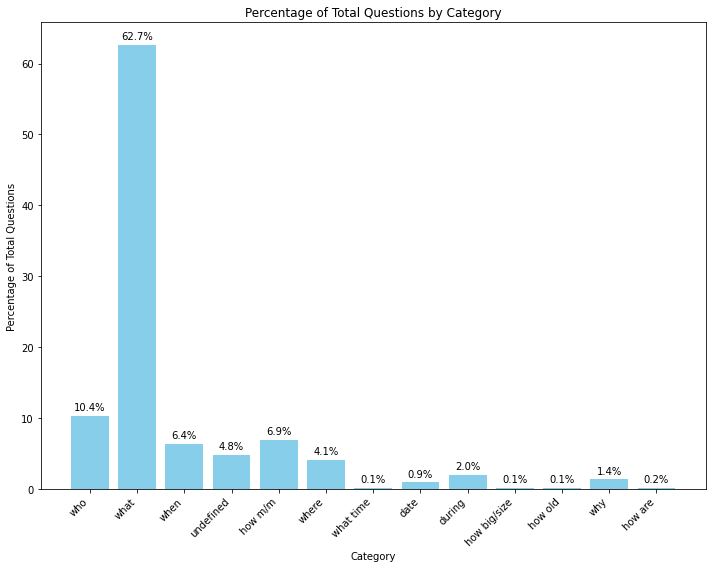

In [10]:
categories = ['who', 'what', 'when', 'undefined', 'how m/m', 'where', 'what time', 'date', 'during', 'how big/size', 'how old', 'why', 'how are']
questions = [9068, 54882, 5599, 4179, 6035, 3601, 129, 800, 1708, 104, 111, 1183, 182]

# Calculate total number of questions
total_questions = sum(questions)

# Calculate percentages for each category
percentages = [(q / total_questions) * 100 for q in questions]

# Now we plot the percentages on the bar chart using Matplotlib
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))
plt.bar(categories, percentages, color='skyblue')

# Adding the percentage values on top of the bars
for i, (category, percentage) in enumerate(zip(categories, percentages)):
    plt.text(i, percentage + 0.5, f'{percentage:.1f}%', ha='center', va='bottom')

plt.xlabel('Category')
plt.ylabel('Percentage of Total Questions')
plt.title('Percentage of Total Questions by Category')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


# Set seed and global variables

In [11]:
### Set seed
torch.manual_seed(42)
np.random.seed(42)

In [12]:
### Global configuration
CONFIG = {
    # For pretrained weight
    "model_checkpoint": "distilbert-base-uncased", # specify pretrained weight from hugging face to use
    # For data preprocessing
    "max_length": 384,
    "stride": 128,
    # For training
    "batch_size": 32,
    "num_train_epochs": 2,
    "output_dir": "frozen-distilbert-custom", # specify output directory to save model
    # For evaluation
    "n_best": 20,
    "max_answer_length": 30
}

In [13]:
### Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(CONFIG["model_checkpoint"])

c:\Users\Jian Cheng\AppData\Local\Programs\Python\Python39\lib\site-packages\huggingface_hub\file_download.py:137: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Jian Cheng\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


# Data preprocessing and preparation

## Preprocess and preparing training dataset

In [14]:
raw_datasets = load_dataset("squad")

In [15]:
train_dataset = raw_datasets["train"].map(
    lambda examples: utils.preprocess_training_examples(examples, tokenizer, CONFIG),
    batched=True,
    remove_columns=raw_datasets["train"].column_names,
)
train_dataset.set_format("torch")
train_dataloader = DataLoader(
    train_dataset,
    shuffle=True,
    collate_fn=default_data_collator,
    batch_size=CONFIG["batch_size"],
)

Map:   0%|          | 0/87599 [00:00<?, ? examples/s]

## Preprocess and preparing validation dataset

In [16]:
validation_dataset = raw_datasets["validation"].map(
    lambda examples: utils.preprocess_validation_examples(examples, tokenizer, CONFIG),
    batched=True,
    remove_columns=raw_datasets["validation"].column_names,
)
validation_set = validation_dataset.remove_columns(["example_id", "offset_mapping"])
validation_set.set_format("torch")
eval_dataloader = DataLoader(
    validation_set, collate_fn=default_data_collator, batch_size=CONFIG["batch_size"]
)

Map:   0%|          | 0/10570 [00:00<?, ? examples/s]

# Load model and freeze/unfreeze bert layers

You can comment out `model.freeze_distilbert()` if you want to fine-tune the bert layers as well.

In [17]:
# Load our custom model with existing pretrained weight
model = DistilBertCustomDense.from_pretrained(CONFIG["model_checkpoint"])
# Freeze bert part
model.freeze_distilbert()

You are using a model of type distilbert to instantiate a model of type distilbertcustom. This is not supported for all configurations of models and can yield errors.


Some weights of DistilBertCustomDense were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['qa_outputs.fc.bias', 'qa_outputs.fc.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Prepare optimizer, scheduler, accelerator

In [18]:
# Optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)

In [19]:
# Accelerator
accelerator = Accelerator(mixed_precision='fp16')
model, optimizer, train_dataloader, eval_dataloader = accelerator.prepare(
    model, optimizer, train_dataloader, eval_dataloader
)

In [20]:
# Scheduler
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps= CONFIG["num_train_epochs"] * len(train_dataloader),
)

# Main Training Loop

In [21]:
progress_bar = tqdm(range(CONFIG["num_train_epochs"] * len(train_dataloader)))

  0%|          | 0/5534 [00:00<?, ?it/s]

In [22]:
for epoch in range(CONFIG["num_train_epochs"]):
    # Training
    model.train()
    for step, batch in enumerate(train_dataloader):
        outputs = model(**batch)
        loss = outputs.loss
        accelerator.backward(loss)

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

    # Evaluation
    model.eval()
    start_logits = []
    end_logits = []
    accelerator.print("Evaluation!")
    for batch in tqdm(eval_dataloader):
        with torch.no_grad():
            outputs = model(**batch)

        start_logits.append(accelerator.gather(outputs.start_logits).cpu().numpy())
        end_logits.append(accelerator.gather(outputs.end_logits).cpu().numpy())

    start_logits = np.concatenate(start_logits)
    end_logits = np.concatenate(end_logits)
    start_logits = start_logits[: len(validation_dataset)]
    end_logits = end_logits[: len(validation_dataset)]

    metrics = utils.compute_metrics(
        CONFIG, start_logits, end_logits, validation_dataset, raw_datasets["validation"]
    )
    print(f"epoch {epoch}:", metrics)

    # Save model
    accelerator.wait_for_everyone()
    unwrapped_model = accelerator.unwrap_model(model)
    unwrapped_model.save_pretrained(CONFIG["output_dir"], save_function=accelerator.save)
    if accelerator.is_main_process:
        tokenizer.save_pretrained(CONFIG["output_dir"])

# Inference using trained model

In [ ]:
# Import necessary classes for pipeline
from model import DistilBertCustomDense, DistilBertCustomConfig
from transformers import DistilBertTokenizer, AutoModelForQuestionAnswering, pipeline

AutoModelForQuestionAnswering.register(DistilBertCustomConfig, DistilBertCustomDense)

In [ ]:
model_checkpoint = CONFIG["output_dir"]

model = DistilBertCustomDense.from_pretrained(model_checkpoint)
tokenizer = DistilBertTokenizer.from_pretrained(model_checkpoint)
question_answerer = pipeline("question-answering", model=model, tokenizer=tokenizer)

context = """
🤗 Transformers is backed by the three most popular deep learning libraries — Jax, PyTorch and TensorFlow — with a seamless integration
between them. It's straightforward to train your models with one before loading them for inference with the other.
"""
question = "Which deep learning libraries back 🤗 Transformers?"
question_answerer(question=question, context=context)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


{'score': 0.004100712016224861, 'start': 83, 'end': 90, 'answer': 'PyTorch'}